### __Notebook to verify that looking at temperature amplitude ratio is interesting for a diffusive problem in the monodirectional case__ ###


In [177]:
#Necessary imports

import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk 
from pyheatmy import * 
from pyheatmy.time_series_multiperiodic import time_series_multiperiodic

from sklearn import linear_model
from pyheatmy.core import *
import scipy

In [178]:
# On commence par créer un signal d'entrée grace à la classe time_series_multiperiodic, que l'on forcera dans la classe Synthetic_Molonari ensuite

T_riv = time_series_multiperiodic("multi_periodic")

# On regarde des variations de température sur une année, on définit une période journalière, et une période annuelle

T_MOY_ANNUELLE = 12 + ZERO_CELSIUS # °C, représente l'offset commun de nos signaux de température

T_AMP_ANNUELLE = 6 # °C, représente l'amplitude de variation de température annuelle

T_AMP_JOURNALIERE = 1 # °C, représente l'amplitude de variation de température journalière

P_an = 12 # Période annuelle en mois

P_jour = 24 # Période journalière, en heures

t_debut = (2024, 4, 15, 8, 0, 0)  # (year, month, day, hour, minute, second)
t_fin = (2024, 4, 20, 8, 0, 0)
dt = int(NSECINHOUR / 4)  #On se place dans le cas d'un point de mesure toutes les heures (à moduler en fonction de l'intervale temporel considéré)

In [179]:
#Ensuite, on commence par créer un objet synthetic_MOLONARI pour pouvoir utiliser ses méthodes (et en particulier accéder à son générateur de dates)

"""Conditions limites"""
# Température de la rivière
zeroT = ZERO_CELSIUS  #time_series works only with forcings in celsius. See if it is deeper in pyheatmy or not

T_riv_amp = 5
T_riv_offset = 20  + zeroT
nday = 3
P_T_riv = nday*NHOURINDAY*4*dt #monthly   period
# Température de l'aquifère
T_aq_amp = 0
T_aq_offset = 12 + zeroT
P_T_aq = -9999 # à mettre dans le init
# Pression différentielle
dH_amp = 0
dH_offset = 0.5 #1meter ?
P_dh = -9999 #14*24*4*dt


depth_sensors = [.1, .2, .3, .4]
Zbottom = 0.4

"""Bruit de mesure"""
sigma_meas_P = 0.001
sigma_meas_T = 0.1

print("dt={0:.1f}s".format(dt))

dt=900.0s


Initializing time series of synthetic_MOLONARI
param_time_dates: [(2024, 4, 15, 8, 0, 0), (2024, 4, 20, 8, 0, 0), 900]
param_dH_signal: [0, -9999, 0.5]
param_T_riv_signal: [5, 259200, 293.15]
param_T_aq_signal: [0, -9999, 285.15]
sigma_meas_P: 0.001
sigma_meas_T: 0.1
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset 0.5, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 5, period of 259200, offset 293.15, dt 900 --> 
periodic signal



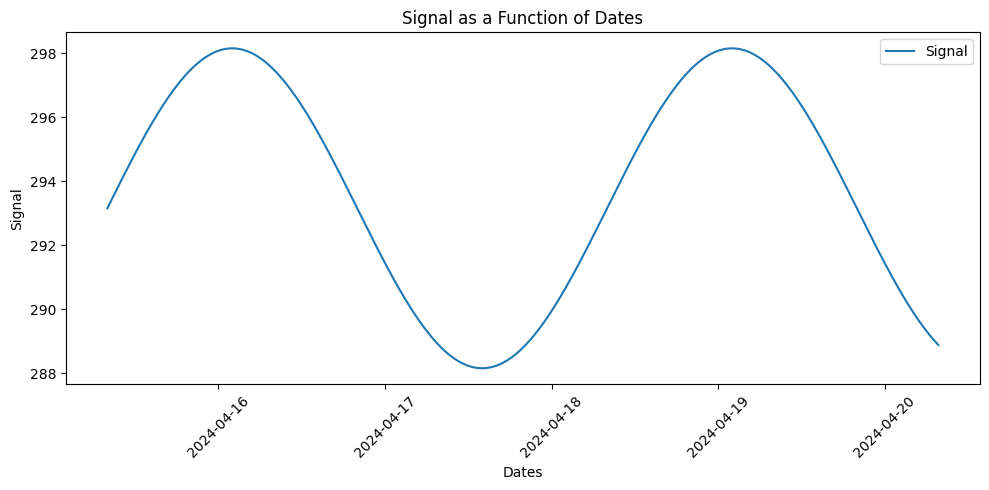

Entering T_aq generation with amplitude 0, period of -9999, offset 285.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.15       291.23180582 291.3135727  291.39526173 291.47683404
 291.55825078 291.63947322 291.7204627  291.80118067 291.88158871
 291.96164855 292.0413221  292.12057142 292.1993588  292.27764675
 292.35539799 292.43257554 292.50914264 292.58506287 292.66030009
 292.73481848 292.80858259 292.8815573  292.95370788 293.025
 293.09539972 293.16487353 293.23338837 293.30091164 293.36741118
 293.43285536 293.49721302 293.56045354 293.62254681 293.68346328
 293.74317396 293.80165043 293.85886486 293.91479001 293.96939928
 294.02266666 294.07456681 294.12507503 294.17416727 294.22182017
 294.26801105 294.31271792 294.35591952 294.39759526 294.43772533
 294.47629062 294.51327278 294.5486542  294.58241805 294.61454825
 294.64502951 294.67384733 294.70098799 294.72643857 294.75018695
 294.77222185 294.79253276 2

In [180]:
"""Reprise du code de dmo_genData pour créer un objet synthetic_MOLONARI"""
# un dictionnaire qui facilite le paramétrage avec des variables globales définies plus haut
time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, #float
}
# instanciation du simulateur de données
emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)


In [181]:
#On print l'attribut date de l'objet créé pour voir si la forme convient 

print(f"Dates : {emu_observ_test_user1._dates}")

Dates : [datetime.datetime(2024, 4, 15, 8, 0)
 datetime.datetime(2024, 4, 15, 8, 15)
 datetime.datetime(2024, 4, 15, 8, 30)
 datetime.datetime(2024, 4, 15, 8, 45)
 datetime.datetime(2024, 4, 15, 9, 0)
 datetime.datetime(2024, 4, 15, 9, 15)
 datetime.datetime(2024, 4, 15, 9, 30)
 datetime.datetime(2024, 4, 15, 9, 45)
 datetime.datetime(2024, 4, 15, 10, 0)
 datetime.datetime(2024, 4, 15, 10, 15)
 datetime.datetime(2024, 4, 15, 10, 30)
 datetime.datetime(2024, 4, 15, 10, 45)
 datetime.datetime(2024, 4, 15, 11, 0)
 datetime.datetime(2024, 4, 15, 11, 15)
 datetime.datetime(2024, 4, 15, 11, 30)
 datetime.datetime(2024, 4, 15, 11, 45)
 datetime.datetime(2024, 4, 15, 12, 0)
 datetime.datetime(2024, 4, 15, 12, 15)
 datetime.datetime(2024, 4, 15, 12, 30)
 datetime.datetime(2024, 4, 15, 12, 45)
 datetime.datetime(2024, 4, 15, 13, 0)
 datetime.datetime(2024, 4, 15, 13, 15)
 datetime.datetime(2024, 4, 15, 13, 30)
 datetime.datetime(2024, 4, 15, 13, 45)
 datetime.datetime(2024, 4, 15, 14, 0)
 dateti

Creating a multi-periodic signal, with the following period: [[24, 'h']] and the following amplitude: [1]
periods : [86400]


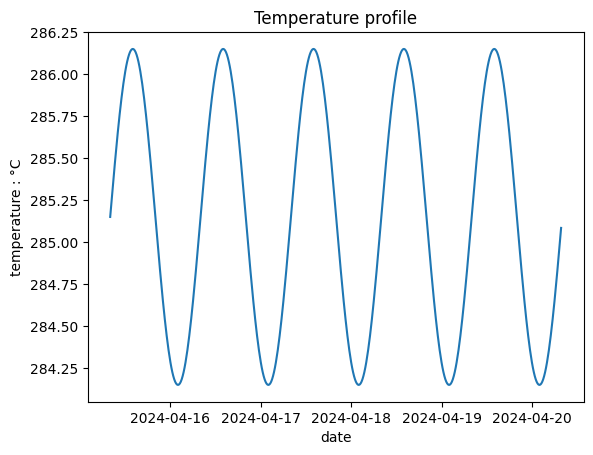

In [182]:
#On utilise le jeu de date précédent pour créer un signal de température multipériodique 

'''T_riv.create_multiperiodic_signal([T_AMP_ANNUELLE, T_AMP_JOURNALIERE], [[P_an, 'm'], [P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)'''

# simple signal
T_riv.create_multiperiodic_signal([T_AMP_JOURNALIERE], [[P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)

T_riv.plot() #On affiche le signal de température créé

In [183]:
#On force la variable T_riv dans l'objet emu_observ_test_user1

emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

#Puis on applique les méthodes _generate_Shaft_Temp_series et _generate_perturb_Shaft_Temp_series pour changer les valeurs dépendante du nouveau T_riv

emu_observ_test_user1._generate_Shaft_Temp_series()
emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
emu_observ_test_user1._generate_perturb_T_riv_dH_series()

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.55498499 284.52639779 284.50048095
 284.47734544 284.45709035 284.4398024  284.42555563 284.41441104
 284

In [184]:
#on génère un objet colonne à partir de l'objet emu_observ_test_user1

name ="Couche en sable"
zLow = Zbottom
moinslog10IntrinK = 11
n = 0.1
lambda_s = 2 # test cas purement advectif
rhos_cs = 4e6

# modèle une couche
layers_list= layersListCreator([(name, zLow, moinslog10IntrinK, n, lambda_s, rhos_cs)])

print(f"Layers list: {layers_list}")

# on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
col_dict = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user1._molonariP_data,
    "T_measures": emu_observ_test_user1._molonariT_data,
    "sigma_meas_P": 0.001,
    "sigma_meas_T": 0.1,
}
col = Column.from_dict(col_dict,verbose=True)

Layers list: [Couche en sable : ends at 0.4 m. Parametres(moinslog10IntrinK=11, n=0.1, lambda_s=2, rhos_cs=4000000.0)]
Column created with success
Number of time steps: 480
Time step in days: 0.010394965277777777
T_riv: [285.06464153 285.20019567 285.13793256 285.40978286 285.40181836
 285.62053823 285.60234467 285.66276607 285.62309631 285.7439846
 285.72628121 285.9380567  285.79827702 285.8140292  285.85434762
 286.11506857 286.04155747 286.06106778 285.99370656 286.20658897
 286.16206535 286.11593545 286.22997764 286.33049911 286.00704891
 286.18321396 286.1985459  286.05197279 286.16038419 286.10318912
 285.97803875 286.10708834 285.95813716 285.93822433 285.84005389
 285.94289461 285.64022192 285.90048656 285.72053282 285.85440653
 285.70258517 285.66245166 285.57261597 285.4698905  285.29873589
 285.37338526 285.38210133 285.27590113 285.1922694  285.23146438
 285.03334762 284.97563406 284.96930484 284.80389031 284.79609393
 284.60859074 284.71399988 284.53339065 284.57244959 28

In [185]:
nb_cells=20 # nombre de cellules, une tous les 5 centimètres 

col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=True)

--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 11, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Solving the flow with intrinsec permeability 1e-11, and permeability 9.810000000000001e-05
Done.


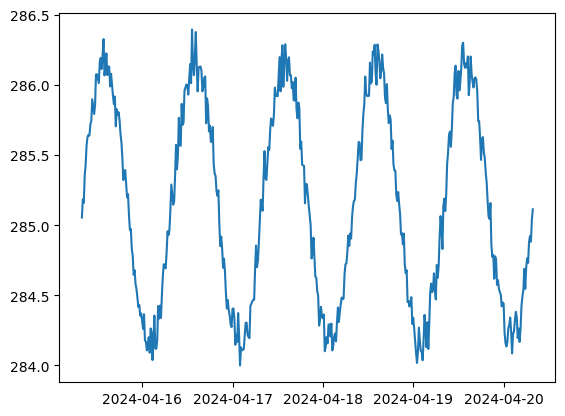

In [186]:
#On vérifie que les températures ont bien été modifiées dans l'objet column (en particulier que la température à profondeur nulle est bien celle de la rivière)

plt.plot(emu_observ_test_user1._dates, col._temperatures[0,:])
plt.show()

In [187]:
print(f"La matrice de température a pour shape : {col._temperatures.shape}, abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps")

La matrice de température a pour shape : (20, 480), abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps


In [188]:
#On définit une fonction pour pouvoir compiler en faisant varier la valeur de la charge (et donc le régime infiltration ou exfiltration vers la 
#rivière) ainsi que la valeur de la porosité (et donc le régime de diffusion de la chaleur - majoritairement diffusif ou advectif)

def profil_temperature(offset_H, moinslog10IntrinK): 
    """Conditions limites"""
    # Température de la rivière
    zeroT = ZERO_CELSIUS  #time_series works only with forcings in celsius. See if it is deeper in pyheatmy or not

    T_riv_amp = 5
    T_riv_offset = 20  + zeroT
    nday = 3
    P_T_riv = nday*NHOURINDAY*4*dt #monthly   period
    # Température de l'aquifère
    T_aq_amp = 0
    T_aq_offset = 14 + zeroT
    P_T_aq = -9999 # à mettre dans le init
    # Pression différentielle
    dH_amp = 0
    P_dh = -9999 #14*24*4*dt


    depth_sensors = [.1, .2, .3, .4]
    Zbottom = 0.4

    """Bruit de mesure"""
    sigma_meas_P = 0.001  #initial value 0.001
    sigma_meas_T = 0.1  # initial value 0.1
    time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, offset_H], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, 
}
    emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)
    
    T_riv.create_multiperiodic_signal([T_AMP_ANNUELLE, T_AMP_JOURNALIERE], [[P_an, 'm'], [P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)
    emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

    emu_observ_test_user1._generate_Shaft_Temp_series()
    emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
    emu_observ_test_user1._generate_perturb_T_riv_dH_series()
    name ="Couche en sable"
    zLow = Zbottom
    n = 0.1
    lambda_s = 2 # test cas purement advectif
    rhos_cs = 4e6

    # modèle une couche
    layers_list= layersListCreator([(name, zLow, moinslog10IntrinK, n, lambda_s, rhos_cs)])

    print(f"Layers list: {layers_list}")

    # on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
    col_dict = {
        "river_bed": 1., 
        "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
        "offset": .0,
        "dH_measures": emu_observ_test_user1._molonariP_data,
        "T_measures": emu_observ_test_user1._molonariT_data,
        "sigma_meas_P": 0.001, #float
        "sigma_meas_T": 0.1, #float
    }
    col = Column.from_dict(col_dict,verbose=False)
    nb_cells=20 # nombre de cellules, une tous les 5 centimètres 

    col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=True)
    return col._temperatures



In [189]:
# Argument : la matrice, liste des profondeur
# Sortie : liste des amplitudes
def amplitude(T):
    amplitude_list = []
    for j in range(len(T[0,:])):
        T_max = max(T[:,j])
        T_min = min(T[:,j])
        A = (T_max - T_min) / 2
        amplitude_list.append(A)
    return amplitude_list


# Retourne ln(rapport des amplitudes) en fonction de la profondeur
def ln_amp(T):
    amplitude_list = amplitude(T)
    amplitude_array = np.array(amplitude_list)
    ln_rapport_amplitude = np.log( amplitude_array / amplitude_array[0] )
    return ln_rapport_amplitude


# Trace le ln_temp(T) en fonction de depths
def plot_ln_amp(depths, T):
    y = ln_amp(T)
    plt.plot(depths, y)
    plt.title("Logarithme du rapport des amplitudes")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.show()


# Renvoie l'instance de régression linéaire des données (profondeur, ln(rapport amplitudes))
def linear_regression(depths, T):
    y = ln_amp(T)
    return scipy.stats.linregress(depths, y)


# Trace l'interpolation linéaire en imprimant le coefficient d'exactitude
def plot_linear_regression(depths, T):
    # assert len(T) == lent(depths), "a temperature measure must be assigned to a single depth"
    X = np.array(depths).reshape(-1,1)
    Y = ln_amp(T)
    Lr = linear_regression(depths, T)
    Pearson_coefficient = Lr.rvalue
    slope = Lr.slope
    intercept = Lr.intercept
    lm = linear_model.LinearRegression()
    lm.fit(X, Y)
    plt.scatter(X, Y, color="r", marker="o", s=30)
    y_pred = lm.predict(X)
    plt.plot(X, y_pred, color="k")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.title("Régression linéaire sur le rapport des logarithmes des amplitudes")
    plt.figtext(.6, .8, "y = " + str(slope) + "x + " + str(intercept))
    plt.figtext(.6, .7, "Pearson coefficient : " + str(Pearson_coefficient))
    plt.show()


# Mosaïque des différentes courbes en fonction des valeurs de K (list_K = liste de ces valeurs)
# T est la liste des matrices de températures pour différentes valeurs de K
def plot_mosaic(depths, list_T, list_K):  
    # assert len(list_T[0]) == lent(depths), "a temperature measure must be assigned to a single depth"
    assert len(list_T) == len(list_K), 'The number of K values does not match the number a temperature matrices'
    n_rows = len(list_K)//2 + len(list_K)%2
    fig, ax = plt.subplots(n_rows, ncols=2, constrained_layout = True)
    X = np.array(depths).reshape(-1,1)
    for i in range(n_rows):
        for j in range(2):
            if 2*i + j < len(list_K):
                Y = ln_amp(list_T[2*i+j])
                Lr = linear_regression(depths, list_T[2*i+j])
                Pearson_coefficient = Lr.rvalue
                slope = Lr.slope
                intercept = Lr.intercept
                lm = linear_model.LinearRegression()
                lm.fit(X, Y)
                ax[i][j].scatter(X, Y, color="r", marker="o", s=30)
                y_pred = lm.predict(X)
                ax[i][j].plot(X, y_pred, color="k")
                ax[i][j].set_xlabel('profondeur (unit)')
                ax[i][j].set_ylabel('log(A_z / A_0)')
                ax[i][j].set_title('Rapport des ln(A_z / A_0) avec -log(K) =' + str(list_K[2*i] + j), size = 10)   
                ax[i][j].text(0.9, 0.9, "Pearson coefficient : " + str(round(Pearson_coefficient,2)), transform=ax[i][j].transAxes, ha='right', va='top')
    plt.show()


In [190]:
# test de plot_linear_regression
# Création d'un jeu de données arbitraire :

def test_plot_linear_regression():
    T = np.zeros((10,10))
    depths = [0.1 * i for i in range(10)]
    for i in range(10):
        for j in range(10):
            T[i,j] = np.sin(i) * np.exp(-j)

    plot_linear_regression(depths, T)

# test de plot_mosaic
# Création de 4 valeurs de K absurde

def test_plot_mosaic():
    T = np.zeros((10,10))
    depths = [0.1 * i for i in range(10)]
    for i in range(10):
        for j in range(10):
            T[i,j] = np.sin(i) * np.exp(-j)
    list_K = range(1,5)
    list_T = [T for _ in range(4)]

    plot_mosaic(depths,list_T,list_K)


Initializing time series of synthetic_MOLONARI
param_time_dates: [(2024, 4, 15, 8, 0, 0), (2024, 4, 20, 8, 0, 0), 900]
param_dH_signal: [0, -9999, 0.05]
param_T_riv_signal: [5, 259200, 293.15]
param_T_aq_signal: [0, -9999, 287.15]
sigma_meas_P: 0.001
sigma_meas_T: 0.1
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset 0.05, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 5, period of 259200, offset 293.15, dt 900 --> 
periodic signal



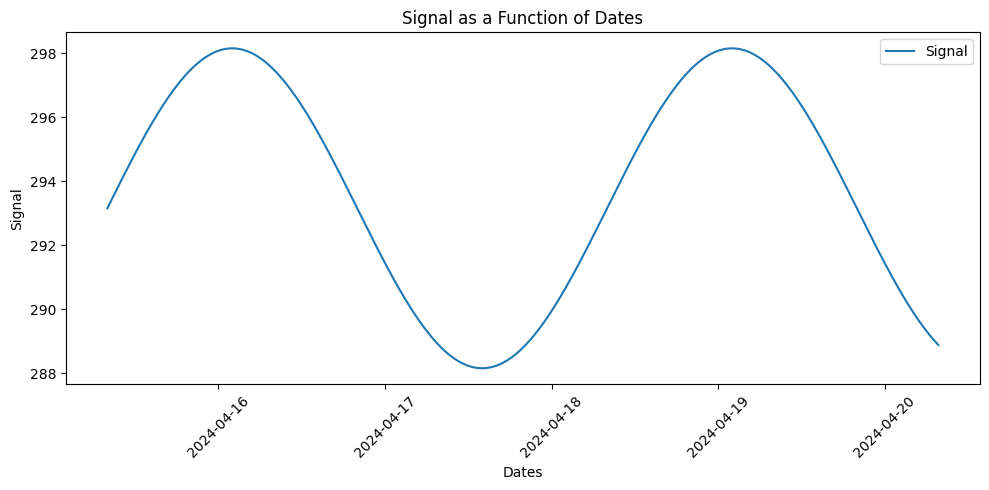

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  291.89526173 291.97683404
 292.05825078 292.13947322 292.2204627  292.30118067 292.38158871
 292.46164855 292.5413221  292.62057142 292.6993588  292.77764675
 292.85539799 292.93257554 293.00914264 293.08506287 293.16030009
 293.23481848 293.30858259 293.3815573  293.45370788 293.525
 293.59539972 293.66487353 293.73338837 293.80091164 293.86741118
 293.93285536 293.99721302 294.06045354 294.12254681 294.18346328
 294.24317396 294.30165043 294.35886486 294.41479001 294.46939928
 294.52266666 294.57456681 294.62507503 294.67416727 294.72182017
 294.76801105 294.81271792 294.85591952 294.89759526 294.93772533
 294.97629062 295.01327278 295.0486542  295.08241805 295.11454825
 295.14502951 295.17384733 295.20098799 295.22643857 295.25018695
 295.27222185 295.29253276 2

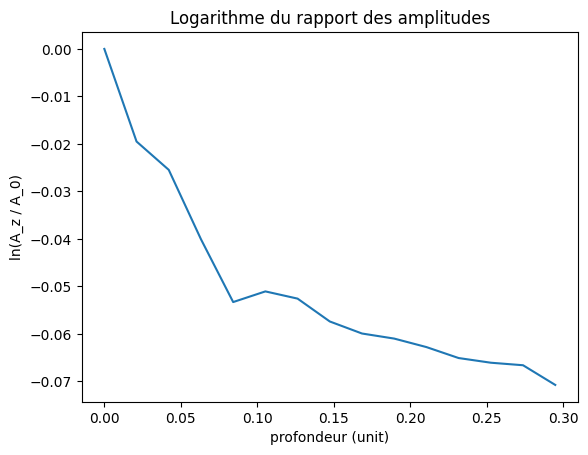

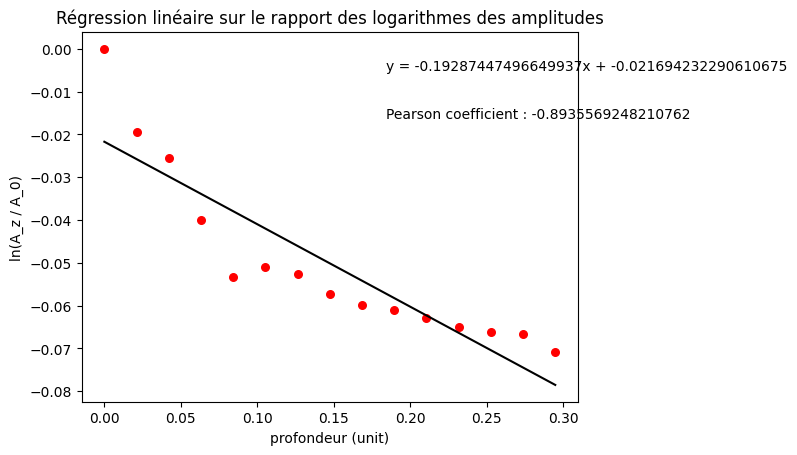

In [191]:
# On se place un jour aléatoire
# n_dt_in_day = int(NSECINDAY / dt)
# day = np.random.randint(0, len(emu_observ_test_user1._dates)-n_dt_in_day)

# On trace la température en fonction de la profondeur pour ce jour

offset_H = 0.05
moinslog10IntrinK = 10

profil_temp = profil_temperature(offset_H, moinslog10IntrinK)[:15,:]

depth_cells = np.linspace(0, 0.4, 20)
plot_ln_amp(depth_cells[0:15], np.transpose(profil_temp))
plot_linear_regression(depth_cells[0:15], np.transpose(profil_temp))


Column created with success
Number of time steps: 480
Time step in days: 0.010394965277777777
T_riv: [285.06464153 285.20019567 285.13793256 285.40978286 285.40181836
 285.62053823 285.60234467 285.66276607 285.62309631 285.7439846
 285.72628121 285.9380567  285.79827702 285.8140292  285.85434762
 286.11506857 286.04155747 286.06106778 285.99370656 286.20658897
 286.16206535 286.11593545 286.22997764 286.33049911 286.00704891
 286.18321396 286.1985459  286.05197279 286.16038419 286.10318912
 285.97803875 286.10708834 285.95813716 285.93822433 285.84005389
 285.94289461 285.64022192 285.90048656 285.72053282 285.85440653
 285.70258517 285.66245166 285.57261597 285.4698905  285.29873589
 285.37338526 285.38210133 285.27590113 285.1922694  285.23146438
 285.03334762 284.97563406 284.96930484 284.80389031 284.79609393
 284.60859074 284.71399988 284.53339065 284.57244959 284.44721691
 284.4275899  284.42682748 284.34104685 284.38628156 284.29506051
 284.2656338  284.38408691 284.12148902 28

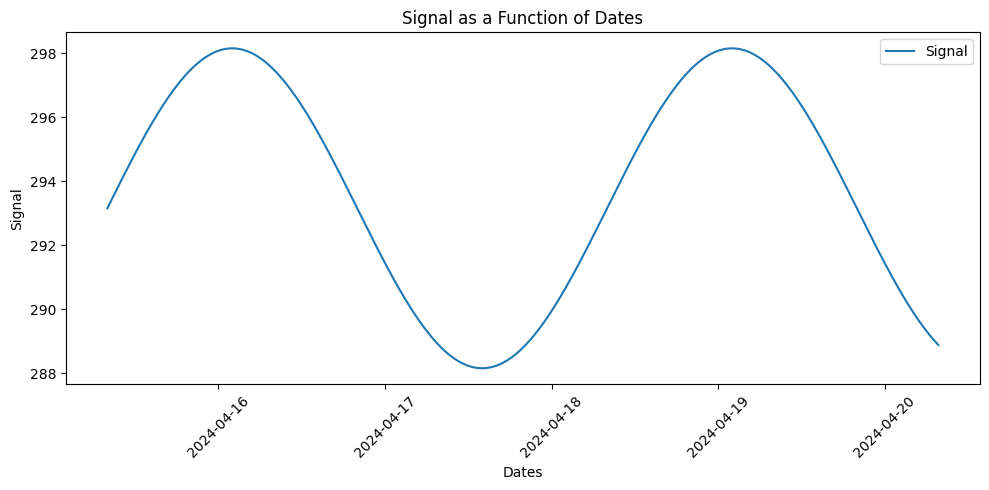

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  291.89526173 291.97683404
 292.05825078 292.13947322 292.2204627  292.30118067 292.38158871
 292.46164855 292.5413221  292.62057142 292.6993588  292.77764675
 292.85539799 292.93257554 293.00914264 293.08506287 293.16030009
 293.23481848 293.30858259 293.3815573  293.45370788 293.525
 293.59539972 293.66487353 293.73338837 293.80091164 293.86741118
 293.93285536 293.99721302 294.06045354 294.12254681 294.18346328
 294.24317396 294.30165043 294.35886486 294.41479001 294.46939928
 294.52266666 294.57456681 294.62507503 294.67416727 294.72182017
 294.76801105 294.81271792 294.85591952 294.89759526 294.93772533
 294.97629062 295.01327278 295.0486542  295.08241805 295.11454825
 295.14502951 295.17384733 295.20098799 295.22643857 295.25018695
 295.27222185 295.29253276 2

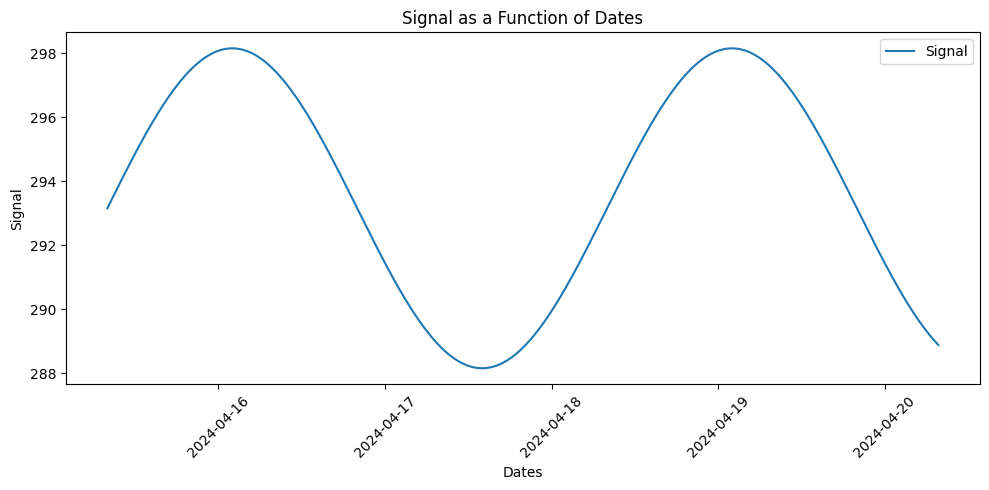

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  291.89526173 291.97683404
 292.05825078 292.13947322 292.2204627  292.30118067 292.38158871
 292.46164855 292.5413221  292.62057142 292.6993588  292.77764675
 292.85539799 292.93257554 293.00914264 293.08506287 293.16030009
 293.23481848 293.30858259 293.3815573  293.45370788 293.525
 293.59539972 293.66487353 293.73338837 293.80091164 293.86741118
 293.93285536 293.99721302 294.06045354 294.12254681 294.18346328
 294.24317396 294.30165043 294.35886486 294.41479001 294.46939928
 294.52266666 294.57456681 294.62507503 294.67416727 294.72182017
 294.76801105 294.81271792 294.85591952 294.89759526 294.93772533
 294.97629062 295.01327278 295.0486542  295.08241805 295.11454825
 295.14502951 295.17384733 295.20098799 295.22643857 295.25018695
 295.27222185 295.29253276 2

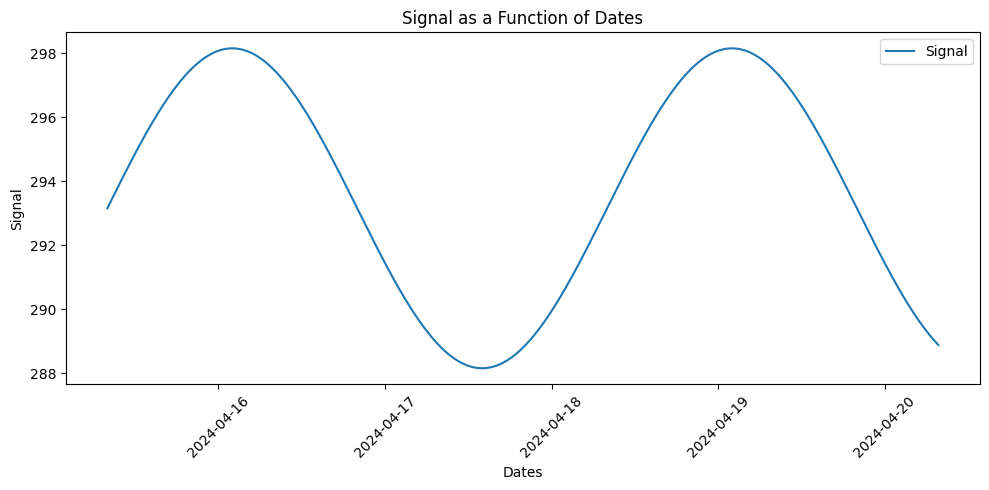

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  291.89526173 291.97683404
 292.05825078 292.13947322 292.2204627  292.30118067 292.38158871
 292.46164855 292.5413221  292.62057142 292.6993588  292.77764675
 292.85539799 292.93257554 293.00914264 293.08506287 293.16030009
 293.23481848 293.30858259 293.3815573  293.45370788 293.525
 293.59539972 293.66487353 293.73338837 293.80091164 293.86741118
 293.93285536 293.99721302 294.06045354 294.12254681 294.18346328
 294.24317396 294.30165043 294.35886486 294.41479001 294.46939928
 294.52266666 294.57456681 294.62507503 294.67416727 294.72182017
 294.76801105 294.81271792 294.85591952 294.89759526 294.93772533
 294.97629062 295.01327278 295.0486542  295.08241805 295.11454825
 295.14502951 295.17384733 295.20098799 295.22643857 295.25018695
 295.27222185 295.29253276 2

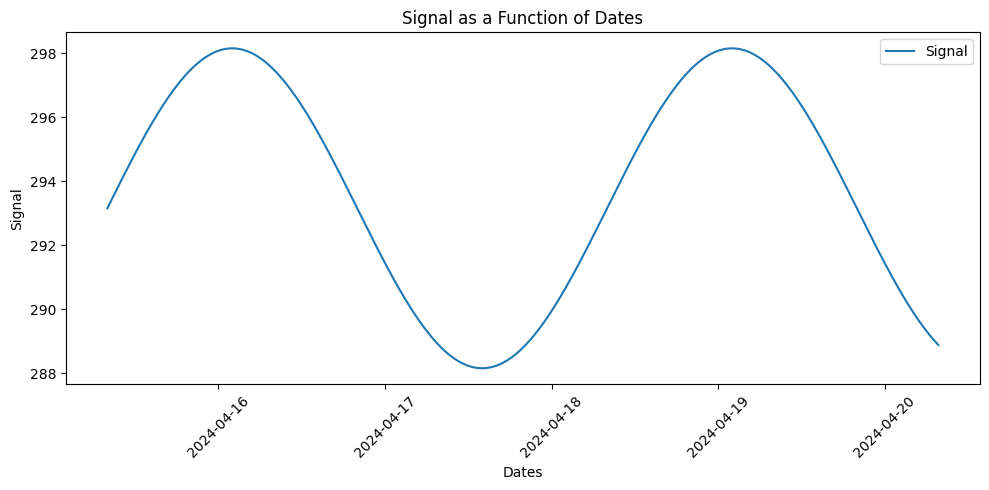

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  291.89526173 291.97683404
 292.05825078 292.13947322 292.2204627  292.30118067 292.38158871
 292.46164855 292.5413221  292.62057142 292.6993588  292.77764675
 292.85539799 292.93257554 293.00914264 293.08506287 293.16030009
 293.23481848 293.30858259 293.3815573  293.45370788 293.525
 293.59539972 293.66487353 293.73338837 293.80091164 293.86741118
 293.93285536 293.99721302 294.06045354 294.12254681 294.18346328
 294.24317396 294.30165043 294.35886486 294.41479001 294.46939928
 294.52266666 294.57456681 294.62507503 294.67416727 294.72182017
 294.76801105 294.81271792 294.85591952 294.89759526 294.93772533
 294.97629062 295.01327278 295.0486542  295.08241805 295.11454825
 295.14502951 295.17384733 295.20098799 295.22643857 295.25018695
 295.27222185 295.29253276 2

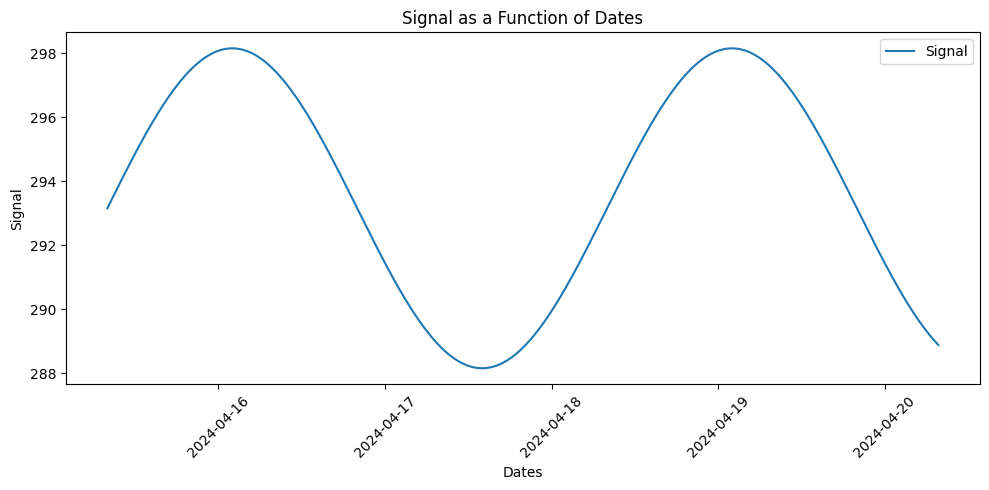

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  291.89526173 291.97683404
 292.05825078 292.13947322 292.2204627  292.30118067 292.38158871
 292.46164855 292.5413221  292.62057142 292.6993588  292.77764675
 292.85539799 292.93257554 293.00914264 293.08506287 293.16030009
 293.23481848 293.30858259 293.3815573  293.45370788 293.525
 293.59539972 293.66487353 293.73338837 293.80091164 293.86741118
 293.93285536 293.99721302 294.06045354 294.12254681 294.18346328
 294.24317396 294.30165043 294.35886486 294.41479001 294.46939928
 294.52266666 294.57456681 294.62507503 294.67416727 294.72182017
 294.76801105 294.81271792 294.85591952 294.89759526 294.93772533
 294.97629062 295.01327278 295.0486542  295.08241805 295.11454825
 295.14502951 295.17384733 295.20098799 295.22643857 295.25018695
 295.27222185 295.29253276 2

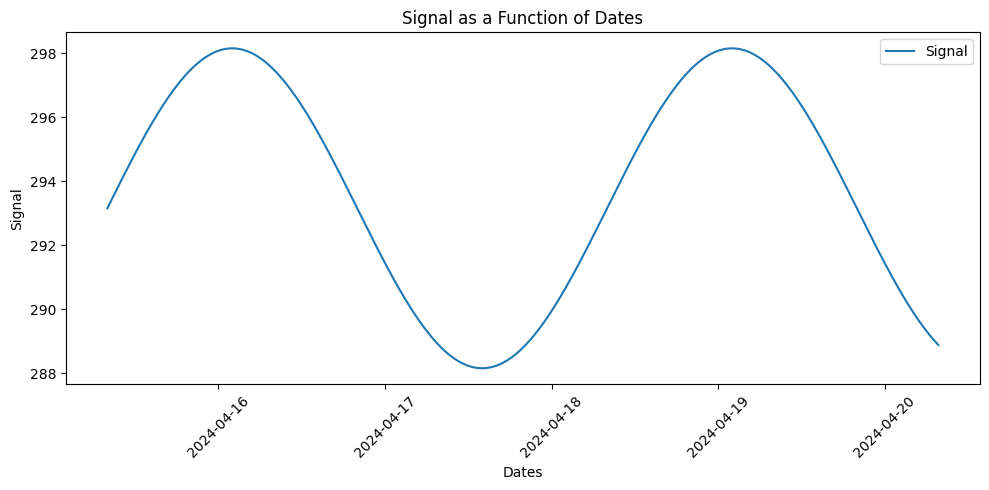

Entering T_aq generation with amplitude 0, period of -9999, offset 287.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [291.65       291.73180582 291.8135727  291.89526173 291.97683404
 292.05825078 292.13947322 292.2204627  292.30118067 292.38158871
 292.46164855 292.5413221  292.62057142 292.6993588  292.77764675
 292.85539799 292.93257554 293.00914264 293.08506287 293.16030009
 293.23481848 293.30858259 293.3815573  293.45370788 293.525
 293.59539972 293.66487353 293.73338837 293.80091164 293.86741118
 293.93285536 293.99721302 294.06045354 294.12254681 294.18346328
 294.24317396 294.30165043 294.35886486 294.41479001 294.46939928
 294.52266666 294.57456681 294.62507503 294.67416727 294.72182017
 294.76801105 294.81271792 294.85591952 294.89759526 294.93772533
 294.97629062 295.01327278 295.0486542  295.08241805 295.11454825
 295.14502951 295.17384733 295.20098799 295.22643857 295.25018695
 295.27222185 295.29253276 2

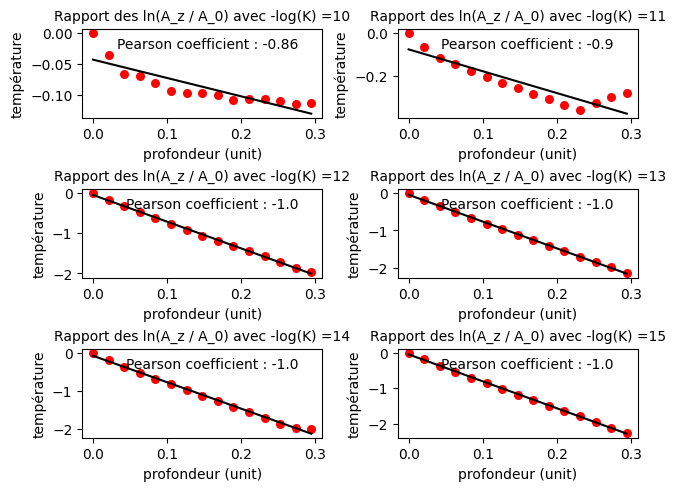

In [192]:
# Plot for different values of K

# returns profile temperature for a given value of K
def temperature_K(moinslog10IntrinK):
    offset_H = 0.05
    nb_cells=20 # nombre de cellules, une tous les 5 centimètres 

    layers_list= layersListCreator([(name, zLow, moinslog10IntrinK, n, lambda_s, rhos_cs)])

    col_dict = {
        "river_bed": 1., 
        "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
        "offset": .0,
        "dH_measures": emu_observ_test_user1._molonariP_data,
        "T_measures": emu_observ_test_user1._molonariT_data,
        "sigma_meas_P": 0.01, #float  !! initial value = 0.01
        "sigma_meas_T": 0.1, #float  !! initial value = 0.1
    }
    col = Column.from_dict(col_dict,verbose=True)
    col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=True)

    profil_temp = profil_temperature(offset_H, moinslog10IntrinK)[:15,:]

    return np.transpose(profil_temp)


def plot_for_several_Kvalues(list_of_log_K_values):
    depth_cells = np.linspace(0, 0.4, 20)[0:15]
    T_list = []
    for l in list_of_log_K_values:
        T_list.append(temperature_K(l))

    plot_mosaic(depth_cells, T_list, list_of_log_K_values)


plot_for_several_Kvalues([10,11,12,13,14,15])